In [26]:
%load_ext autoreload
%autoreload 2

%pwd
%cd /home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments
%matplotlib inline 

import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments


In [21]:
import pathlib
import sys

DATA_FOLDER = pathlib.Path("/home/benji/Documents/Uni/heidelberg/05/masterarbeit/datasets/better-types-4-py-dataset")

from datetime import datetime, timezone
import logging


logger = logging.getLogger(name=__name__)
logger.setLevel(level=logging.DEBUG)

handler = logging.StreamHandler(stream=sys.stdout)
handler.setFormatter(fmt=logging.Formatter('%(asctime)s | %(levelname)s : %(message)s'))
logger.addHandler(handler)

In [22]:
from scripts.infer.structure import AuthorRepo
from typet5.data import GitRepo

class BetterTypes4PyRepo(GitRepo):
    def __init__(self, author_repo: AuthorRepo) -> None:
        author, repo = str(author_repo).split("__")
        super().__init__(
            author=author, 
            name=repo,
            url=None,
            stars=-1,
            forks=-1
        )

    def repo_dir(self, repos_dir: pathlib.Path) -> pathlib.Path:
        return repos_dir / "repos" / "test" / self.authorname()

In [4]:
from typet5.data import GitRepo, get_dataset_dir
from typet5.type_env import collect_annots_info, mypy_checker
from typet5.utils import proj_root, read_file, write_file, not_none

import tqdm

from scripts.infer.structure import BetterTypes4Py

dataset = BetterTypes4Py(dataset_root=DATA_FOLDER)
test_set = dataset.test_set()
assert test_set

downloaded_repos = [BetterTypes4PyRepo(dataset.author_repo(test_repo)) for test_repo in test_set]

for r in tqdm.tqdm(downloaded_repos):
    r.read_last_update(DATA_FOLDER)

date_threshold = datetime(2021, 4, 20)
new_repos = [r for r in downloaded_repos if not_none(r.last_update) > date_threshold]
logger.info(f"{len(new_repos)} / {len(downloaded_repos)} repos were updated within a year.")

new_repos = [r for r in new_repos if "typeshed" not in r.name and "stub" not in r.name]
logger.info(f"{len(new_repos)} / {len(downloaded_repos)} are not additionally related to stubbing")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.38it/s]

2023-06-22 13:48:18,173 | INFO : 50 / 50 repos were updated within a year.
2023-06-22 13:48:18,173 | INFO : 49 / 50 are not additionally related to stubbing


In [5]:
loc_limit = 50000

small_repos = []
all_repos = []
for rep in tqdm.tqdm(new_repos):
    try:
        loc = rep.count_lines_of_code(DATA_FOLDER)
        if loc < loc_limit:
            small_repos.append(rep)
        else:
            logger.warning(f"{rep.authorname()} does not pass, with {loc} LOC")
    except UnicodeDecodeError:
        # nothing we can do
        logger.warning(f"{rep.authorname()} does not pass due to encoding error", exc_info=True)
    except Exception as e:
        logger.warning(f"{rep.authorname()} does not pass", exc_info=True)

    else:
        all_repos.append(rep)

print(
    f"{len(small_repos)}/{len(new_repos)} repos are within the size limit ({loc_limit} LOC)."
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 139.21it/s]

49/49 repos are within the size limit (50000 LOC).


[0, 4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000]


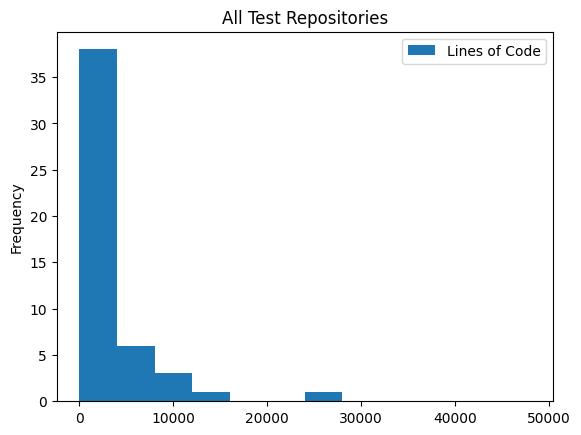

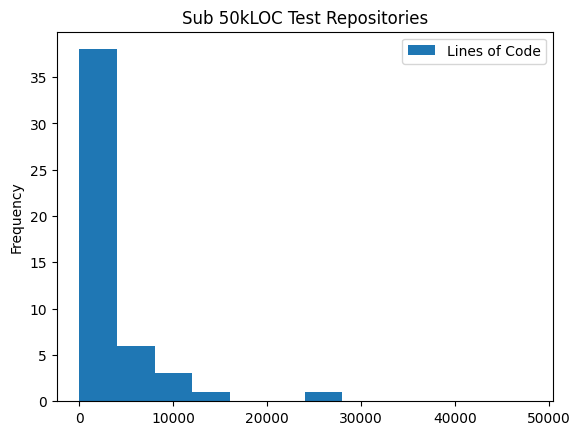

In [23]:
# Bin by lines of code
import pandas as pd

kloc = loc_limit // 1000
LOC_BINS = [loc * 1000 for loc in range(0, kloc + 1, 4)]
print(LOC_BINS)

def loc_binning(repos: list[GitRepo], title: str) -> None:
    repo_loc = pd.DataFrame(
        [(repo.authorname(), repo.lines_of_code) for repo in repos],
        columns=["Repository", "Lines of Code"]
    )
    repo_loc.plot.hist(ylabel="Frequency", bins=LOC_BINS, title=title)


loc_binning(all_repos, title="All Test Repositories")
loc_binning(small_repos, title="Sub 50kLOC Test Repositories")

In [6]:
import operator
from scripts import utils

def count_repo_annots(rep) -> tuple[GitRepo, dict] | None:
    try:
        annotations = rep.collect_annotations(DATA_FOLDER)
        if rep.n_type_annots / rep.lines_of_code > 0.05:
            return rep, annotations
    except Exception as e:
        logger.warning(f"Failed to count annotations for {rep.name}. Exception: {e}")
        return None

from concurrent.futures import ProcessPoolExecutor, as_completed

with ProcessPoolExecutor(max_workers=4) as executor:
    fs = [executor.submit(count_repo_annots, r) for r in small_repos]
    repo2annotations = [f.result() for f in tqdm.tqdm(as_completed(fs), total=len(fs))]

repo2annotations: list[tuple[BetterTypes4PyRepo, dict]] = [r for r in repo2annotations if r is not None]
useful_repos: list[BetterTypes4PyRepo] = list(map(operator.itemgetter(0), repo2annotations))


logger.info(
    f"{len(useful_repos)}/{len(small_repos)} repos are parsable, have enough portions of type annotations"
)

del repo2annotations

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:32<00:00,  1.53it/s]

2023-06-22 13:48:57,749 | INFO : 49/49 repos are parsable, have enough portions of type annotations


In [7]:
from scripts.common.schemas import TypeCollectionSchema, TypeCollectionCategory
from scripts.common.output import DatasetIO

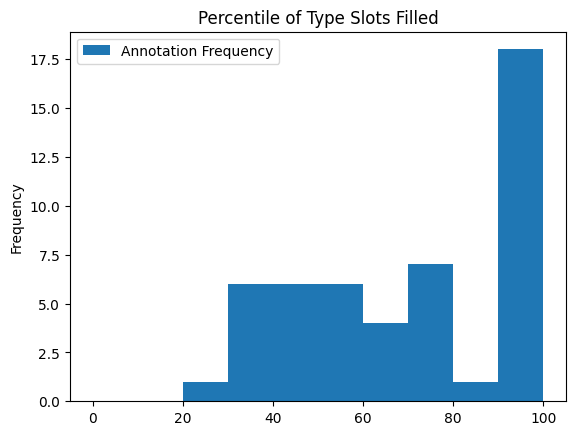

In [8]:
# Bin by relative annotation count
def type_slots_filled(repos: list[GitRepo], title: str) -> None:
    anno_df = pd.DataFrame(
        [(repo.authorname(), repo.n_type_annots / repo.n_type_places * 100) for repo in repos],
        columns=["Repository", "Annotation Frequency"]
    )
    bins = [x for x in range(0, 100 + 1, 10)]
    anno_df.plot.hist(ylabel="Frequency", bins=bins, title=title)

type_slots_filled(useful_repos, title="Percentile of Type Slots Filled")


In [9]:
from scripts.common.schemas import TypeCollectionSchema, TypeCollectionCategory
from scripts.common.output import DatasetIO

from pandera import typing as pt

collected_symbols = list()
for repo in (bar := tqdm.tqdm(useful_repos)):
    bar.set_description(str(repo))

    d = DatasetIO(
        artifact_root=pathlib.Path.cwd(), 
        dataset=dataset,
        repository=repo.repo_dir(DATA_FOLDER)
    )

    df = d.read()
    df["project"] = str(dataset.author_repo(repo.repo_dir(DATA_FOLDER)))
    collected_symbols.append(df)

print(useful_repos[0].repo_dir(DATA_FOLDER), collected_symbols[0], sep="\n")

BetterTypes4PyRepo(author='nabla-c0d3', name='sslyze', url=None, stars=-1, forks=-1, description='', lines_of_code=12092, last_update=datetime.datetime(2023, 4, 1, 15, 29, 11), n_type_annots=1157, n_type_places=1470): 100%|█| 49/49 [00:00


/home/benji/Documents/Uni/heidelberg/05/masterarbeit/datasets/better-types-4-py-dataset/repos/test/ocf__slackbridge
                         file            category                                             qname                                          qname_ssa                                               anno           project
0     slackbridge/messages.py     CALLABLE_RETURN                             SlackMessage.__init__                              SlackMessage.__init__                                                NaN  ocf__slackbridge
1     slackbridge/messages.py  CALLABLE_PARAMETER                        SlackMessage.__init__.self                         SlackMessage.__init__.self                                                NaN  ocf__slackbridge
2     slackbridge/messages.py  CALLABLE_PARAMETER                 SlackMessage.__init__.raw_message                  SlackMessage.__init__.raw_message            builtins.dict[builtins.str, typing.Any]  ocf__slackbridge
3   

                                   project   coverage
0                   albertyw__albertyw.com  42.316785
1                         ocf__slackbridge  47.978437
2     Gerschtli__teamspeak-update-notifier  51.724138
3                 linw1995__data_extractor  17.925387
4       ShadowTemplate__beautiful-python-3  24.810127
5                rakitaj__daily-programmer  28.013877
6                    eirannejad__calcatime  32.786885
7              road-master__video-archiver  31.503580
8                          ohjames__babies  17.198582
9                           cliffxuan__mew  37.387387
10           yeraydiazdiaz__wait_for_it.py  22.580645
11                        seattleflu__id3c  31.179039
12                        joshtemple__lkml  23.090586
13                      sonic182__aiosonic  17.257319
14           reddit__baseplate.py-upgrader  29.460581
15                    AxelVoitier__lookups  17.504435
16          amplify-education__python-hcl2  37.444934
17                 flopp__un

/tmp/ipykernel_4134/3806997668.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


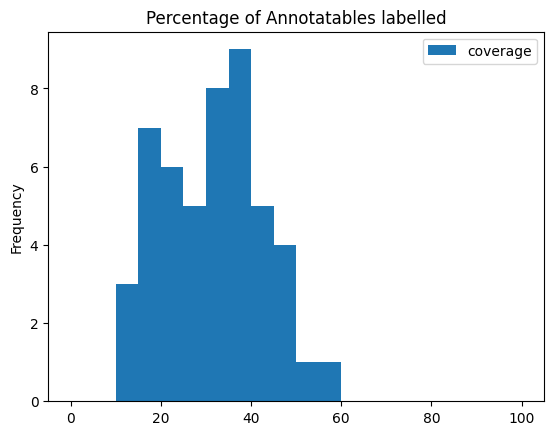

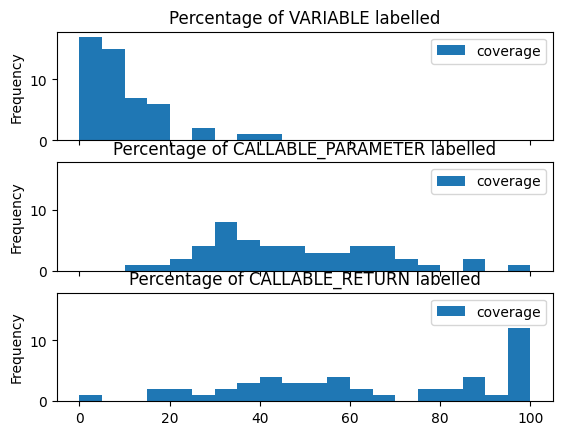

In [28]:
import matplotlib.pyplot as plt

SYMBOL_BINS = [x for x in range(0, 100 + 1, 5)]

def symbols_labelled_normalised(repos: list[pd.DataFrame], title: str) -> None:
    labelled_df = pd.DataFrame(
        [(df["project"].iloc[0], df[TypeCollectionSchema.anno].notna().sum() / len(df[TypeCollectionSchema.anno]) * 100) for df in repos], 
        columns=["project", "coverage"]
    )
    print(labelled_df)
    labelled_df.plot.hist(ylabel="Frequency", bins=SYMBOL_BINS, title=title)

def symbols_by_category_labelled(repos: list[pd.DataFrame], title: str) -> None:
    categories = [TypeCollectionCategory.VARIABLE, TypeCollectionCategory.CALLABLE_PARAMETER, TypeCollectionCategory.CALLABLE_RETURN]
    fig, axes = plt.subplots(len(categories), sharex=True, sharey=True)
    for (ax, category) in zip(axes, categories):
        category_repos = [r.drop(r[r[TypeCollectionSchema.category] != category].index) for r in repos]
        labelled_df = pd.DataFrame(
            [(df["project"].iloc[0], df[TypeCollectionSchema.anno].notna().sum() / len(df[TypeCollectionSchema.anno]) * 100) for df in category_repos], 
            columns=["project", "coverage"]
        )
        print(labelled_df)
        labelled_df.plot.hist(ylabel="Frequency", bins=SYMBOL_BINS, title=title.format(category=category), ax=ax)

    fig.show()
    

symbols_labelled_normalised(collected_symbols, title="Percentage of Annotatables labelled")
symbols_by_category_labelled(collected_symbols, title="Percentage of {category} labelled")

49
49
[0, 4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000]
repository       object
Lines of Code     int64
dtype: object


<Axes: title={'center': 'Sub 50kLOC Test Repositories'}, ylabel='Frequency'>

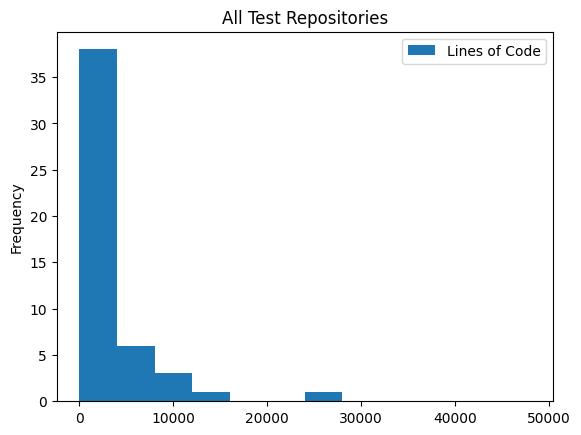

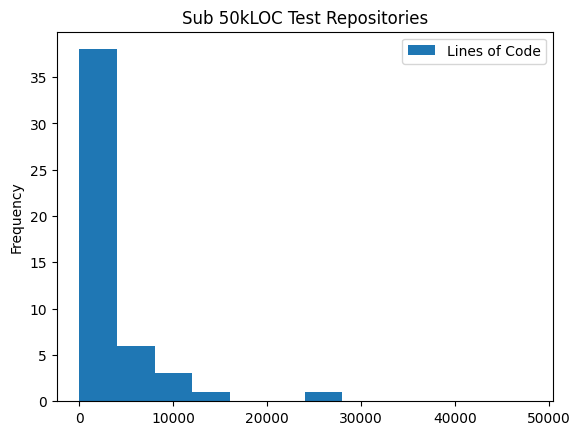

In [29]:
# Bin by lines of code
import pandas as pd

print(len(small_repos))
print(len(useful_repos))

kloc = loc_limit // 1000
LOC_BINS = [loc * 1000 for loc in range(0, kloc + 1, 4)]
print(LOC_BINS)

all_repo_loc = pd.DataFrame(
    [(repo.authorname(), repo.lines_of_code) for repo in all_repos],
    columns=["repository", "Lines of Code"]
)
all_repo_loc.plot.hist(xlabel="Lines of Code", ylabel="Frequency", bins=LOC_BINS, title="All Test Repositories")

small_repo_loc = pd.DataFrame(
    [(repo.authorname(), repo.lines_of_code) for repo in small_repos],
    columns=["repository", "Lines of Code"]
)
print(small_repo_loc.dtypes)
small_repo_loc.plot.hist(xlabel="Lines of Code", ylabel="Frequency", bins=LOC_BINS, title="Sub 50kLOC Test Repositories")

# TypeT5 \& MDTI4PY Parity

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 106.71it/s]


                                   project  mdti4py  typet5  deviation
34                             jreese__aql      265     299         34
35                   kornicameister__axion     1132    1161         29
37                 basilisp-lang__basilisp     3428    3456         28
38             paulcwatts__drf-json-schema      378     400         22
48                      nabla-c0d3__sslyze     1140    1157         17
26  lucaswerkmeister__tool-quickcategories      815     831         16
3                 linw1995__data_extractor      197     210         13
33       scalableminds__webknossos-connect      761     774         13
12                        joshtemple__lkml      260     270         10
15                    AxelVoitier__lookups      296     305          9
28               antonagestam__collectfast      163     171          8
45                    futursolo__magichttp      362     368          6
22                kitsuyui__bamboo-crawler      222     228          6
13    

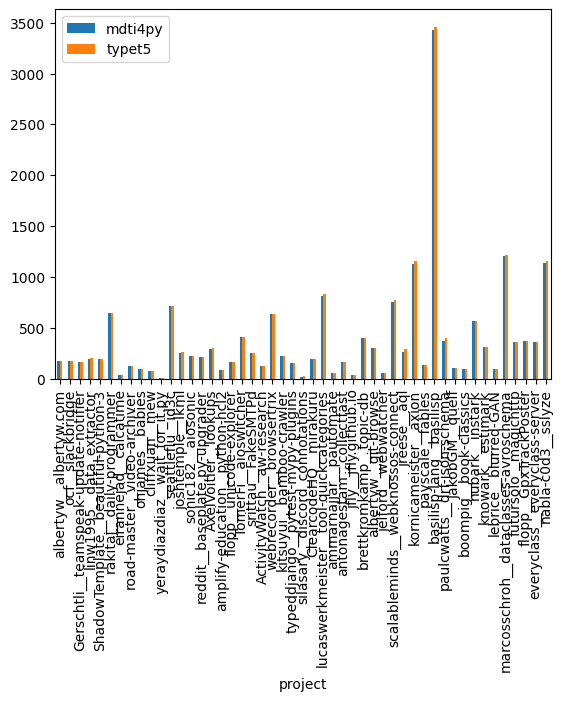

In [30]:
anno_counting = []

for repo in (bar := tqdm.tqdm(useful_repos)):
    d = DatasetIO(
        artifact_root=pathlib.Path.cwd(), 
        dataset=dataset,
        repository=repo.repo_dir(DATA_FOLDER)
    )

    mdti4py = d.read()
    mdti4py_counting = mdti4py[TypeCollectionSchema.anno].notna().sum()
    anno_counting.append((repo.authorname(), mdti4py_counting, repo.n_type_annots))

df = pd.DataFrame(anno_counting, columns=["project", "mdti4py", "typet5"])
df["deviation"] = (df["mdti4py"] - df["typet5"]).abs()
print(df.sort_values(by="deviation", ascending=False))
df.plot.bar(x="project", y=["mdti4py", "typet5"])
print(df["deviation"].mean())

del anno_counting, df

# TypeT5 \& Type4Py Parity

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


                                   project  mdti4py  type4py  deviation
37                 basilisp-lang__basilisp     3428     3476         48
34                             jreese__aql      265      299         34
35                   kornicameister__axion     1132     1161         29
38             paulcwatts__drf-json-schema      378      400         22
48                      nabla-c0d3__sslyze     1140     1157         17
26  lucaswerkmeister__tool-quickcategories      815      831         16
3                 linw1995__data_extractor      197      212         15
33       scalableminds__webknossos-connect      761      774         13
25                   ClearcodeHQ__mirakuru      193      205         12
12                        joshtemple__lkml      260      270         10
15                    AxelVoitier__lookups      296      305          9
28               antonagestam__collectfast      163      171          8
45                    futursolo__magichttp      362      368    

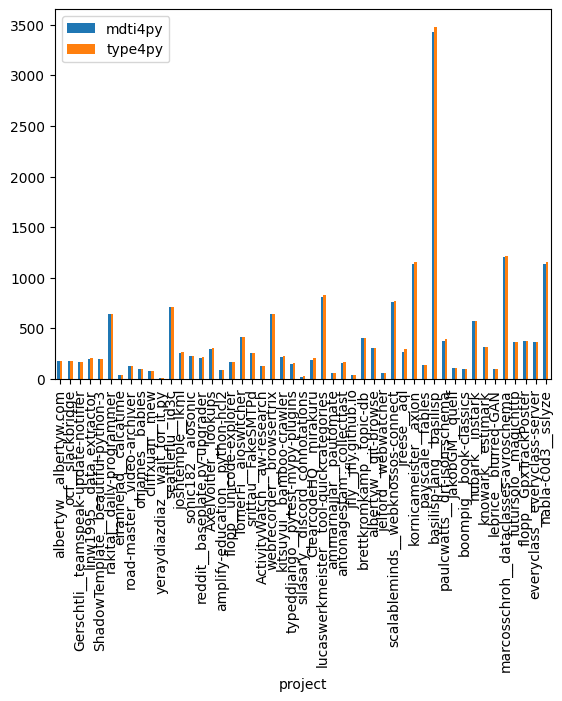

In [31]:
import libcst
from libcst import codemod
from libsa4py.cst_visitor import TypeAnnotationCounter

anno_counting = []

for repo in (bar := tqdm.tqdm(useful_repos)):
    d = DatasetIO(
        artifact_root=pathlib.Path.cwd(), 
        dataset=dataset,
        repository=repo.repo_dir(DATA_FOLDER)
    )

    mdti4py = d.read()
    mdti4py_counting = mdti4py[TypeCollectionSchema.anno].notna().sum()

    visitor = TypeAnnotationCounter()
    for file in codemod.gather_files([str(repo.repo_dir(DATA_FOLDER))]):
        libcst.parse_module(pathlib.Path(file).read_text()).visit(visitor)

    anno_counting.append((repo.authorname(), mdti4py_counting, visitor.total_no_type_annot))

df = pd.DataFrame(anno_counting, columns=["project", "mdti4py", "type4py"])
df["deviation"] = (df["mdti4py"] - df["type4py"]).abs()
print(df.sort_values(by="deviation", ascending=False))
df.plot.bar(x="project", y=["mdti4py", "type4py"])
print(df["deviation"].mean())

del anno_counting, df

In [10]:
dataclasses = next(filter(lambda r: r.authorname() == "linw1995__data_extractor", useful_repos), None)
print(dataclasses)
d = DatasetIO(
    artifact_root=pathlib.Path.cwd(), 
    dataset=dataset,
    repository=dataclasses.repo_dir(DATA_FOLDER)
)

repo_groundtruth = d.read()

# print(repo_groundtruth.drop(columns=["qname_ssa"]).dropna())

variables = repo_groundtruth[repo_groundtruth["category"] == TypeCollectionCategory.VARIABLE]
print("Coverage for Variables: ", variables["anno"].notna().sum() / len(variables))

parameters = repo_groundtruth[repo_groundtruth["category"] == TypeCollectionCategory.CALLABLE_PARAMETER]
print("Coverage for Parameters: ", parameters["anno"].notna().sum() / len(parameters))

returns = repo_groundtruth[repo_groundtruth["category"] == TypeCollectionCategory.CALLABLE_RETURN]
print("Coverage for Returns: ", returns["anno"].notna().sum() / len(returns))

BetterTypes4PyRepo(author='linw1995', name='data_extractor', url=None, stars=-1, forks=-1, description='', lines_of_code=3309, last_update=datetime.datetime(2022, 4, 16, 0, 6, 38), n_type_annots=210, n_type_places=530)
Coverage for Variables:  0.037037037037037035
Coverage for Parameters:  0.3016759776536313
Coverage for Returns:  0.34328358208955223


In [30]:
# Ensure preprocessing has gone as we would like

all_ground_truths_without_nas = pd.concat([
    DatasetIO(
        artifact_root=pathlib.Path.cwd(), 
        dataset=dataset,
        repository=repo.repo_dir(DATA_FOLDER)
    ).read().dropna().assign(repository=repo.repo_dir(DATA_FOLDER).name) for repo in useful_repos
])

def ensure_missing(df: pd.DataFrame, ty: str) -> None:
    matching = all_ground_truths_without_nas.loc[all_ground_truths_without_nas["anno"].str.startswith(ty)]
    print(ty, matching[[
        "repository",
        TypeCollectionSchema.file,
        TypeCollectionSchema.category,
        TypeCollectionSchema.qname_ssa,
        TypeCollectionSchema.anno,
    ]].to_string(), "\n", sep="\n")
    # assert matching.empty

ensure_missing(all_ground_truths_without_nas, "typing.Dict")
ensure_missing(all_ground_truths_without_nas, "Dict")

ensure_missing(all_ground_truths_without_nas, "typing.List")
ensure_missing(all_ground_truths_without_nas, "List")

ensure_missing(all_ground_truths_without_nas, "typing.Set")
ensure_missing(all_ground_truths_without_nas, "Set")

ensure_missing(all_ground_truths_without_nas, "typing.Tuple")
ensure_missing(all_ground_truths_without_nas, "Tuple")

ensure_missing(all_ground_truths_without_nas, "typing.Optional")
ensure_missing(all_ground_truths_without_nas, "Optional")


# Manually checked: these match typing.TextIO, but no Text or typing.Text
ensure_missing(all_ground_truths_without_nas, "Text")
ensure_missing(all_ground_truths_without_nas, "typing.Text")


def ensure_no_nestage(df: pd.DataFrame, ty: str) -> None:
    matching = all_ground_truths_without_nas.loc[all_ground_truths_without_nas["anno"].str.count(ty) > 1]
    print(ty, matching[[
        "repository",
        TypeCollectionSchema.file,
        TypeCollectionSchema.category,
        TypeCollectionSchema.qname_ssa,
        TypeCollectionSchema.anno,
    ]].to_string(), "\n", sep="\n")
    # assert matching.empty
    
ensure_no_nestage(all_ground_truths_without_nas, "typing\.Union")
ensure_no_nestage(all_ground_truths_without_nas, "Union")

typing.Dict
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


Dict
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


typing.List
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


List
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


typing.Set
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


Set
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


typing.Tuple
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


Tuple
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


typing.Optional
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


Optional
Empty DataFrame
Columns: [repository, file, category, qname_ssa, anno]
Index: []


Text
                        repository                             file     

In [28]:
print(all_ground_truths_without_nas[[
    "repository",
    TypeCollectionSchema.file,
    TypeCollectionSchema.category,
    TypeCollectionSchema.qname_ssa,
    TypeCollectionSchema.anno,
]].sample(n=20))

                              repository                                             file            category                                          qname_ssa                                               anno
5170             basilisp-lang__basilisp              src/basilisp/lang/compiler/nodes.py            VARIABLE                                        PyDict.opλ1            src.basilisp.lang.compiler.nodes.NodeOp
655                   nabla-c0d3__sslyze            sslyze/plugins/robot/_robot_tester.py  CALLABLE_PARAMETER  _RobotTlsRecordPayloads.get_client_key_exchang...                                       builtins.int
496              brettkromkamp__topic-db                  src/topicdb/store/topicstore.py  CALLABLE_PARAMETER               TopicStore.get_topics.map_identifier                                       builtins.int
1039               kornicameister__axion                                axion/__init__.py     CALLABLE_RETURN                                 _plugins.t

In [ ]:
"""from typet5 import type_check

MYPY_LOCATION = pathlib.Path.cwd().parent / "experiments" / ".venv" / "bin"
assert MYPY_LOCATION.is_dir()

for useful_repo in tqdm.tqdm(useful_repos):
    path = useful_repo.repo_dir(DATA_FOLDER)
    output = type_check.MypyChecker.check_project(
        proj=path,
        binary_path=MYPY_LOCATION
    )
    if isinstance(output, str) or output.num_errors > 0 or output.error_dict:
        print(path, output)"""